# Inference problem on Hilbert Model space

In [1]:
import numpy as np
from pygeoinf import linalg
import scipy.integrate as spi
from scipy.special import legendre
from sola.main_classes import functions, domains
from sola.aux import predefined_functions
from sola.aux import integration
import matplotlib.pyplot as plt

Display found. Using TkAgg backend.
Display found. Using TkAgg backend.


## Define spaces and mappings

### Define D and P

In [2]:
# Define the data and property spaces
D_dim = 5
P_dim = 1

D = linalg.EuclideanSpace(D_dim)
P = linalg.EuclideanSpace(P_dim)

### Define M

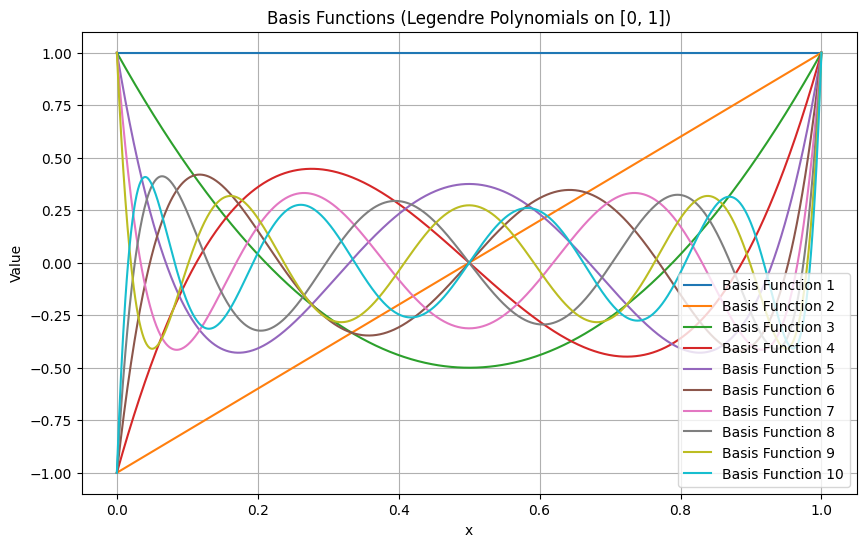

In [3]:
%matplotlib inline
# Define Model space

# Discretization of the model space
M_dim = 10

# Define the basis functions (Legendre polynomials on [0,1])
domain = domains.HyperParalelipiped([[0, 1]])
basis_functions_evaluation = [
    lambda x, n=n: legendre(n)(2 * x - 1)
    for n in range(M_dim)
]
basis_functions = [
    functions.Function(
        domain,
        evaluate_callable=basis_function
    )
    for basis_function in basis_functions_evaluation
]

# Plot the basis functions

# Evaluate each basis function on the domain
plt.figure(figsize=(10, 6))
for i, basis_function in enumerate(basis_functions):
    plt.plot(domain.mesh, basis_function.evaluate(domain.mesh), label=f"Basis Function {i+1}")

# Add labels, title, and legend
plt.title("Basis Functions (Legendre Polynomials on [0, 1])")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

In [4]:
# Define the inner product on the model space
def M_inner_product(f: functions.Function, g: functions.Function):
    return integration.integrate_continuous(f*g)

# Convert function to coefficients (projection onto basis)
def M_to_components(f: functions.Function, basis_functions):
    return [
        M_inner_product(f, basis_function)
        for basis_function in basis_functions
    ]

# Convert coefficients back to function (linear combination)
def M_from_components(c, M_dim):
    function_evaluation = lambda x: sum(
        c[i] * basis_functions[i].evaluate(x)
        for i in range(M_dim)
    )
    return functions.Function(
        domain,
        evaluate_callable=function_evaluation
    )

M = linalg.HilbertSpace(M_dim, lambda f: M_to_components(f, basis_functions),
                        lambda c: M_from_components(c, M_dim),
                        M_inner_product)

### Define G

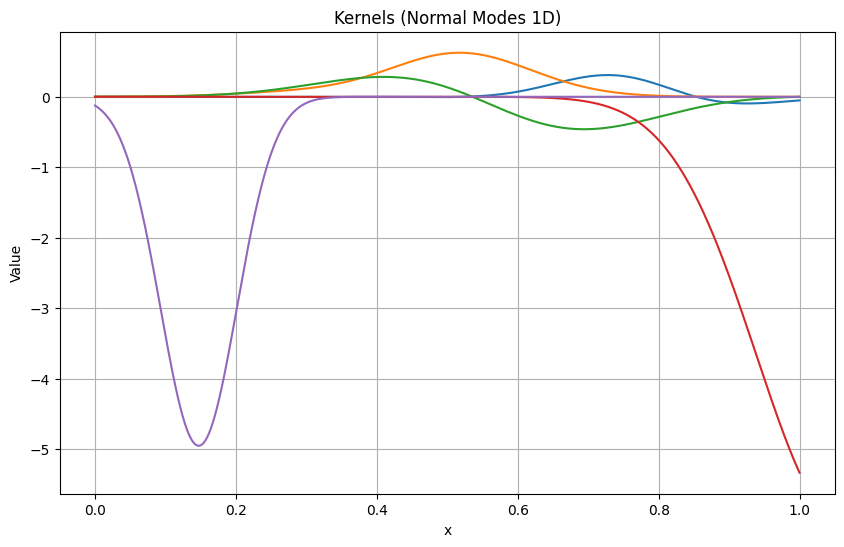

In [5]:
# Define G mapping
kernels = [
    predefined_functions.NormalModes_1D(
        domain, order=10, spread=0.1, max_freq=10
    ) for _ in range(D_dim)
]

# Plot all the kernels
plt.figure(figsize=(10, 6))

for i, kernel in enumerate(kernels):
    y = kernel.evaluate(domain.mesh)  # Evaluate the kernel on the domain's mesh
    plt.plot(domain.mesh, y, label=f"Kernel {i+1}")

# Add labels, title, and legend
plt.title("Kernels (Normal Modes 1D)")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.show()

In [6]:
# Define the G mapping function
# This function maps a function `f` in the model space to a vector in the data space
# by computing the inner product of `f` with each kernel in the `kernels` list.
def G_mapping(f: functions.Function, kernels):
    return np.array([M.inner_product(f, kernel) for kernel in kernels])

# Define the linear operator G
# This operator maps from the model space (M) to the data space (D) using the G_mapping function.
G = linalg.LinearOperator(M, D, lambda f: G_mapping(f, kernels))

### Define T

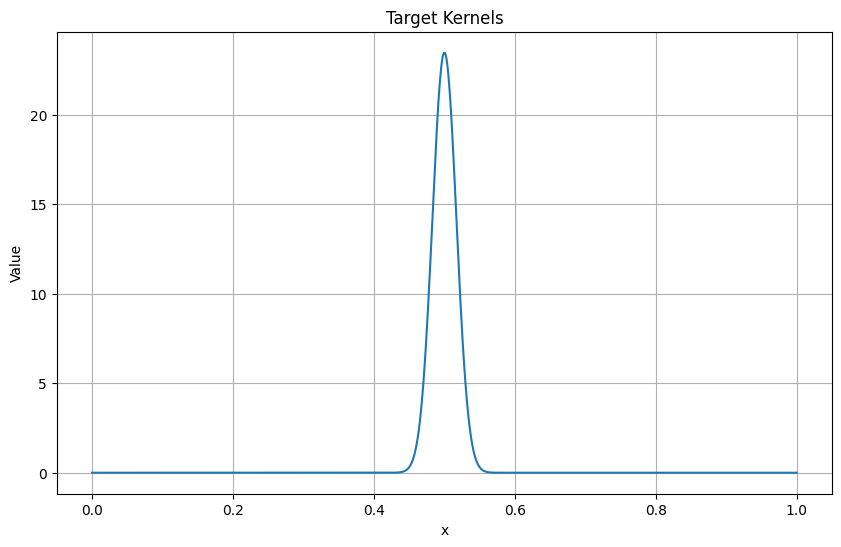

In [7]:
# Define G mapping
targets = [
    predefined_functions.Gaussian_1D(domain, center=0.5, width=0.1)
    for i in range(P_dim)
]

# Plot all the kernels
plt.figure(figsize=(10, 6))

for i, target in enumerate(targets):
    y = target.evaluate(domain.mesh)  # Evaluate the kernel on the domain's mesh
    plt.plot(domain.mesh, y, label=f"Kernel {i+1}")

# Add labels, title, and legend
plt.title("Target Kernels")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.show()

In [8]:
# Define the T mapping function
# This function maps a function `f` in the model space to a vector in the property space
# by computing the inner product of `f` with each target in the `targets` list.
def T_mapping(f: functions.Function, targets):
    return np.array([M.inner_product(f, target) for target in targets])

# Define the linear operator T
# This operator maps from the model space (M) to the property space (P) using the T_mapping function.
T = linalg.LinearOperator(M, P, lambda f: T_mapping(f, targets))

## Find least norm solution

### Find $\Lambda$

We find the matrix of $\Lambda$ and make it into an operator

In [9]:
G.matrix(dense=True)

array([[ 4.09495544e-02,  1.34206102e-02, -1.65520281e-02,
        -2.43385715e-02, -9.20473740e-03,  8.90775776e-03,
         1.29520479e-02,  4.40205373e-03, -4.04762076e-03,
        -4.88842554e-03],
       [ 1.71397093e-01,  1.91100602e-04, -7.10027105e-02,
        -2.61738580e-03,  3.59886522e-02,  4.46520978e-03,
        -1.77471617e-02, -4.12538633e-03,  8.44921934e-03,
         2.60971618e-03],
       [-4.55186561e-02, -6.24712099e-02, -3.93896421e-03,
         5.39263286e-02,  1.97687643e-02, -2.57553796e-02,
        -1.45788487e-02,  8.01716372e-03,  6.43210599e-03,
        -1.67473479e-03],
       [-5.70875338e-01, -4.81819760e-01, -3.38001693e-01,
        -1.88904995e-01, -7.43187542e-02, -9.42855366e-03,
         1.36484309e-02,  1.34249171e-02,  6.37417611e-03,
         1.06228994e-03],
       [-6.68516230e-01,  4.71265937e-01, -1.75448003e-01,
        -8.14164464e-02,  2.01818932e-01, -1.74822037e-01,
         6.51183180e-02,  3.97719282e-02, -8.37712632e-02,
         6.

In [10]:
# Step 1: Compute GG^*
Lambda = G @ G.adjoint
Lambda_matrix = Lambda.matrix(dense=True)

# Assuming `matrix` is the matrix representation (e.g., a NumPy array)
def Lambda_mapping(x, D, Lambda_matrix):
    components = D.to_components(x)  # Convert vector to components
    result_components = Lambda_matrix @ components  # Apply the matrix
    return D.from_components(result_components)  # Convert back to vector

# Create the LinearOperator
Lambda = linalg.LinearOperator(D, D, lambda x: Lambda_mapping(x, D, Lambda_matrix))

In [11]:
print("Lambda_matrix:\n", Lambda_matrix)

Lambda_matrix:
 [[ 1.25730345e-02  6.72019029e-03 -1.96143576e-02  2.52609390e-02
  -4.71359247e-04]
 [ 6.72019029e-03  7.22007235e-02  1.41907747e-03 -2.21252489e-03
  -2.00836142e-02]
 [-1.96143576e-02  1.41907747e-03  4.95115898e-02  4.07726827e-02
  -1.84964540e-02]
 [ 2.52609390e-02 -2.21252489e-03  4.07726827e-02  1.89989549e+00
  -4.64735996e-04]
 [-4.71359247e-04 -2.00836142e-02 -1.84964540e-02 -4.64735996e-04
   2.29282748e+00]]


In [12]:
# Step 2: Compute (GG^*)^-1 using a solver
solver = linalg.CGSolver(rtol=1e-8, atol=1e-10, maxiter=1000)  # Conjugate Gradient Solver
Lambda_inv = solver(Lambda)

# Step 3: Compose G^* with (GG^*)^-1
Inverse = G.adjoint @ Lambda_inv

# Print the resulting operator
print("Operator G^* (GG^*)^-1 computed successfully.")

Operator G^* (GG^*)^-1 computed successfully.


### Create fake model and data

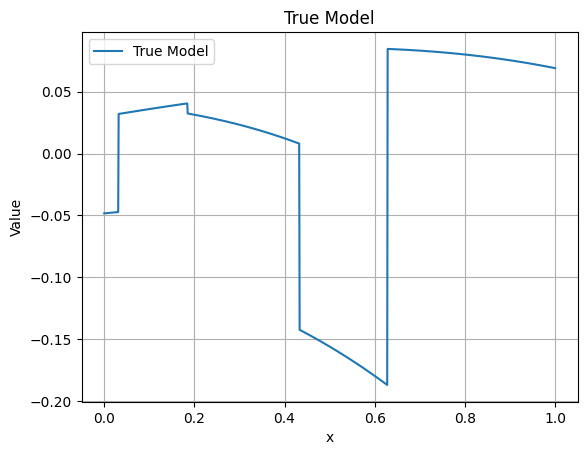

In [13]:
# Fake Model
m_true = predefined_functions.Random_1D(domain, seed=44)

plt.plot(domain.mesh, m_true.evaluate(domain.mesh), label="True Model")
plt.title("True Model")
plt.xlabel("x")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

# Fake data
d = G(m_true)

In [14]:
# Find least norm solution
solution = Inverse(d)

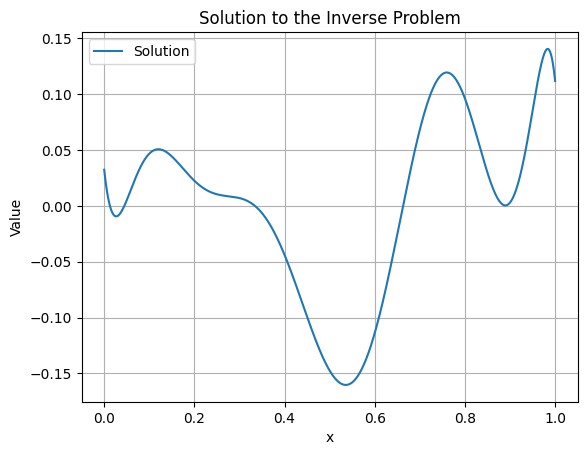

In [15]:
plt.plot(domain.mesh, solution.evaluate(domain.mesh), label="Solution")
plt.title("Solution to the Inverse Problem")
plt.xlabel("x")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

## Questions 

1. Why is there no option to cache the matrix representation of a LinearOperator? 
2. Why is there only a finite vector space class? I know that inherently anything will be eventually discretized because we work on computers, but I still think there would be some use to an infinite dimensional class that pushes discretization further down the line. 